This notebook illustrates how to convert the raw ADC radar data to RAD matrics.

Dataset: 
[UWCR](https://github.com/Xiangyu-Gao/Radar-multiple-perspective-object-detection/tree/aff04b354f07f2689dfd8fcf6fcb68a9404eb73a)

In [30]:
import os
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import PIL.Image as Image

In [31]:
IMG_DIR = 'images_0'
RAW_RADAR_DIR = 'radar_raw_frame'
# Define the data path
data_path = 'data/UWCR/Automotive/'
dir_name = '2019_04_30_pbss000'
idx = 300

In [32]:
# Radar configuration
n_angle = 128
n_vel = 255
n_range = 128
n_chirp = 255
n_ant = 8  # number of antennas = n_tx * n_rx
n_sample = 128
noma_rcs = 30000

In [33]:
file_dir = os.path.join(data_path, dir_name, RAW_RADAR_DIR)
files = sorted(os.listdir(file_dir))

img_dir = os.path.join(data_path, dir_name, IMG_DIR)
img_files = sorted(os.listdir(img_dir))

file = files[idx]
print('Radar file:', file)

file_name = file.split('.')[0]

img_file = f'0000{file_name}.jpg'
print('Image file:', img_file)

Radar file: 000302.mat
Image file: 0000000302.jpg


Image size: (1440, 1080)


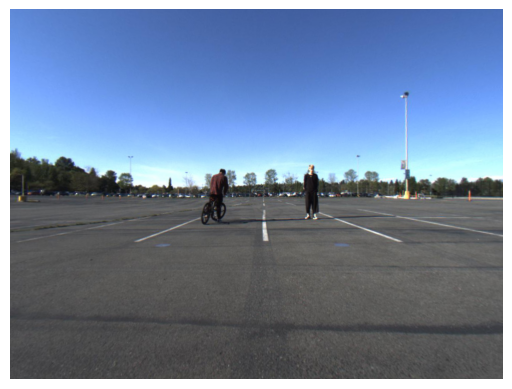

In [34]:
# Visualize the corresponding image
img_path = os.path.join(img_dir, img_file)

# Load the image
img = Image.open(img_path)
print('Image size:', img.size)
# show the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [35]:
# Load the first .mat file
file_path = os.path.join(file_dir, file)

# Load the .mat file
mat = spio.loadmat(file_path, squeeze_me=True)

ADC_data = mat['adcData']
print('ADC data shape (samples, chirps, receivers, transmitters):', ADC_data.shape)

ADC data shape (samples, chirps, receivers, transmitters): (128, 255, 4, 2)


In [36]:
# Reshape the data from (n_sample, n_chirp, n_rx, n_tx) to (n_sample, n_antenna, n_chirp)
ADC_data = np.transpose(ADC_data, (0, 1, 3, 2)) # (n_sample, n_chirp, n_rx, n_tx) -> (n_sample, n_chirp, n_tx, n_rx)
print('ADC data shape:', ADC_data.shape)
ADC_data = ADC_data.reshape(n_sample, n_chirp, n_ant)
ADC_data = np.transpose(ADC_data, (0, 2, 1))
print('ADC data shape:', ADC_data.shape)

ADC data shape: (128, 255, 2, 4)
ADC data shape: (128, 8, 255)


In [37]:
# Range FFT
def range_fft(data):
    """
    Perform range FFT on radar data.

    Args:
        data (ndarray): Radar data with shape [n_sample, n_ant, n_chirp].
        n_sample (int): Number of samples.

    Returns:
        ndarray: Range FFT result with shape [n_sample, n_ant, n_chirp].

    """
    hamming = np.hamming(data.shape[0])
    win_data = np.zeros([data.shape[0], data.shape[1], data.shape[2]], dtype=np.complex128)
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            win_data[:, i, j] = np.multiply(data[:, i, j], hamming)
    fft_data = np.fft.fft(win_data, axis=0)

    return fft_data

In [38]:
# Doppler FFT
def doppler_fft(data):
    """
    Perform Doppler FFT on radar data.

    Args:
        data (ndarray): Input radar data after Range FFT with shape [n_range, n_ant, n_chirp].
        n_vel (int): Number of velocity bins.   

    Returns:
        ndarray: Doppler FFT result with shape [n_range, n_ant, n_doppler].
    """
    hamming_win = np.hamming(data.shape[2])
    win_data = np.zeros([data.shape[0], data.shape[1], data.shape[2]], dtype=np.complex128)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            win_data[i, j, :] = np.multiply(data[i, j, :], hamming_win)

    fft_data = np.fft.fft(win_data, axis=2)
    fft_data = np.fft.fftshift(fft_data, axes=2)

    return fft_data

In [39]:
# Angle FFT
def angle_fft_on_rd(data, n_ant):
    """
    Perform angle FFT on range-Doppler data.

    Args:
        data (ndarray): Input range-Doppler data with shape (n_range, n_ant, n_doppler).
        n_ant (int): Number of antennas.

    Returns:
        ndarray: RAD (Range-Angle-Doppler) data with shape (n_range, n_angle, n_doppler)
    """
    hamming_win = np.hamming(n_ant)
    win_data = np.zeros([data.shape[0], n_ant, data.shape[2]], dtype=np.complex128)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            win_data[i, :, j] = np.multiply(data[i, :, j], hamming_win)

    fft_data = np.fft.fft(win_data, n_angle, axis=1)
    fft_data = np.fft.fftshift(fft_data, axes=1)

    return fft_data

In [40]:
# Run the range FFT
data_range_fft = range_fft(ADC_data)
print('Range FFT data shape:', data_range_fft.shape)

# Run the Doppler FFT
data_doppler_fft = doppler_fft(data_range_fft)
print('Doppler FFT data shape:', data_doppler_fft.shape)

# Run the Angle FFT
data_angle_fft = angle_fft_on_rd(data_doppler_fft, n_ant)

RAD_data = data_angle_fft
print('RAD data shape:', RAD_data.shape)

Range FFT data shape: (128, 8, 255)
Doppler FFT data shape: (128, 8, 255)
RAD data shape: (128, 128, 255)


As we set the n_angle to 128, so the second dimension of the RAD matrix is 128. It only gives a larger number of angle bins, but resolution of each bin is reduced to n_antenna/n_angle, which means each of the original n_antenna bins is divided into n_angle/n_antenna smaller bins. (It gives a large resolution of the range angle map, makes it looks more smooth.)

#### Recovering the Range-Angle Map and the Range-Doppler Map from the RAD matrix

In [41]:
# Recover the Range-Angle map
def to_ra(data):
    """
    Convert the RAD (Range-Angle-Doppler) data to Range-Angle data.

    Args:
        data (ndarray): Input RAD data with shape (n_range, n_angle, n_doppler).

    Returns:
        ndarray: Range-Angle data with shape (n_range, n_angle).
    """
    data_ra = np.max(np.abs(data), axis=2)
    data_ra = 20 * np.log10(data_ra / np.max(data_ra))
    return data_ra

RAD data (Range-Angle) shape: (128, 128)


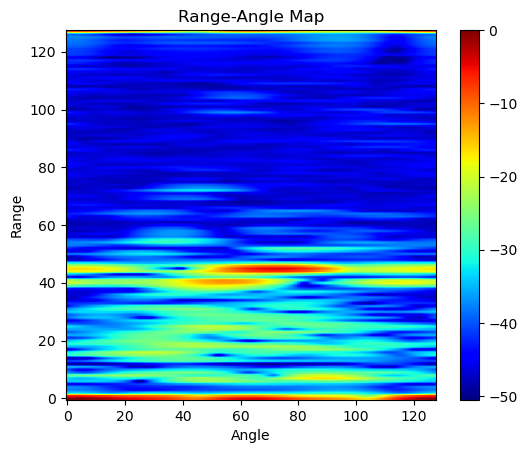

In [42]:
# Convert the RAD data to Range-Angle data
RAD_data_ra = to_ra(RAD_data)
print('RAD data (Range-Angle) shape:', RAD_data_ra.shape)

# Visualize the Range-Angle map, set the origin to the bottom-left corner
plt.imshow(RAD_data_ra, cmap='jet', origin='lower')
plt.colorbar()
plt.xlabel('Angle')
plt.ylabel('Range')
plt.title('Range-Angle Map')
plt.show()

In [43]:
# Recover the Range-Doppler map
def to_rd(data):
    """
    Convert the RAD (Range-Angle-Doppler) data to Range-Doppler data.

    Args:
        data (ndarray): Input RAD data with shape (n_range, n_angle, n_doppler).

    Returns:
        ndarray: Range-Doppler data with shape (n_range, n_doppler).
    """
    # Undo the angle FFT
    data_rd = np.fft.ifftshift(data, axes=1)
    data_rd = np.fft.ifft(data_rd, axis=1)
    data_rd = pow(np.abs(data_rd), 2)
    data_rd = np.sum(data_rd, axis=1)
    data_rd_log = 10 * np.log10(data_rd + 1e-10)

    return data_rd_log

RAD data (Range-Doppler) shape: (128, 255)


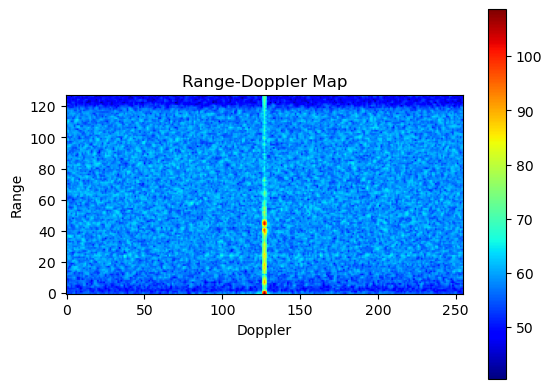

In [44]:
# Convert the RAD data to Range-Doppler data
RAD_data_rd = to_rd(RAD_data)
print('RAD data (Range-Doppler) shape:', RAD_data_rd.shape)

# Visualize the Range-Doppler map, set the origin to the bottom-left corner
plt.imshow(RAD_data_rd, cmap='jet', origin='lower')
plt.colorbar()
plt.xlabel('Doppler')
plt.ylabel('Range')
plt.title('Range-Doppler Map')
plt.show()

In [45]:
# # Recover the Range-Doppler map
def to_rd2(data):
    """
    Convert the RAD (Range-Angle-Doppler) data to Range-Doppler data.
    (This func directly sum the absolute value of the data along the angle dimension)
    Args:
        data (ndarray): Input RAD data with shape (n_range, n_angle, n_doppler).

    Returns:
        ndarray: Range-Doppler data with shape (n_range, n_doppler).
    """
    data_rd = np.sum(np.abs(data), axis=1)
    data_rd = 20 * np.log10(data_rd)
    return data_rd

RAD data (Range-Doppler) shape: (128, 255)


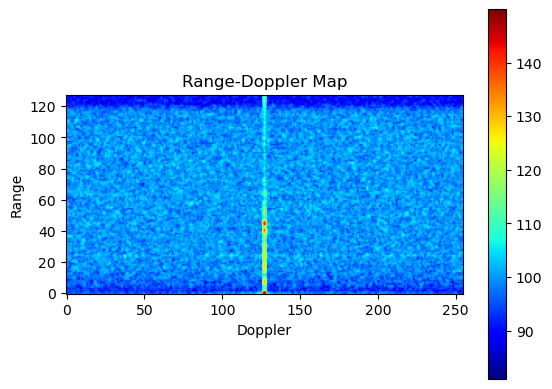

In [46]:
# Convert the RAD data to Range-Doppler data
RAD_data_rd2 = to_rd2(RAD_data)
print('RAD data (Range-Doppler) shape:', RAD_data_rd2.shape)

# Visualize the Range-Doppler map, set the origin to the bottom-left corner
plt.imshow(RAD_data_rd2, cmap='jet', origin='lower')
plt.colorbar()
plt.xlabel('Doppler')
plt.ylabel('Range')
plt.title('Range-Doppler Map')
plt.show()